# Import Packages

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from ovm.monetary.model import MonetaryModel

import logging
import os
import random
import typing as tp

import line_profiler
import matplotlib.pyplot as plt
%matplotlib inline
# %matplotlib notebook
# %matplotlib widget
from mesa.datacollection import DataCollector
from mesa.visualization.ModularVisualization import ModularServer
from mesa.visualization.modules import ChartModule
import numpy as np
import pandas as pd
import chart_studio.plotly as py
import plotly.express as px
import plotly.graph_objs as go
import seaborn as sns
from tqdm import tqdm

from ovm.monetary.agents import (
    MonetaryAgent, 
    MonetaryArbitrageur, 
    MonetaryKeeper, 
    MonetaryLiquidator, 
    MonetarySniper
)

from ovm.monetary.markets import MonetaryFMarket
from ovm.monetary.model import MonetaryModel
from ovm.monetary.options import DataCollectionOptions
from ovm.monetary.plot_labels import (
    price_deviation_label,
    spot_price_label,
    futures_price_label,
    skew_label,
    inventory_wealth_ovl_label,
    inventory_wealth_usd_label,
    GINI_LABEL,
    GINI_ARBITRAGEURS_LABEL,
    SUPPLY_LABEL,
    TREASURY_LABEL,
    LIQUIDITY_LABEL, 
)

from ovm.monetary.plots import (
    DEFAULT_FIGURE_SIZE, 
    convert_time_interval_in_seconds_to_indices, 
    construct_full_time_axis, 
    construct_time_axis, 
    get_indices_and_time_axis_to_plot, 
    plot_multiple_variables_over_time, 
    plot_price_deviations, 
    plot_skews, 
    plot_open_positions, 
    plot_single_variable_over_time, 
    plot_supply, 
    plot_treasury, 
    plot_liquidity, 
    plot_spot_vs_futures_price, 
)

from ovm.monetary.reporters import * 
from ovm.monetary.data_io import (
    construct_sims_map, 
    construct_ticker_to_series_of_prices_map_from_simulated_prices
)

from ovm.paths import (
    HistoricalDataSource, 
    construct_historical_data_directory
)

from ovm.simulation.bootstrap import plot_multivariate_simulation
from ovm.simulation.resampling import (
    load_log_returns,
    simulate_new_price_series_via_bootstrap,
    store_simulated_price_series_in_output_directory
)

from ovm.tickers import (
    ETH_USD_TICKER,
    COMP_USD_TICKER,
    LINK_USD_TICKER,
    YFI_USD_TICKER
)

from ovm.time_resolution import (
    TimeResolution, 
    TimeScale
)

environment variable OVERLAY_MONETARY_BASE_PATH not set defaulting to /home/michael/PycharmProjects/overlay-monetary


In [3]:
logger = logging.getLogger(__name__)
logger.level

0

In [4]:
logging.getLevelName(logging.root.level)

'WARNING'

In [5]:
logging.root.level

30

In [6]:
%load_ext line_profiler

# Set Parameters

In [7]:
time_resolution = TimeResolution.FIFTEEN_SECONDS

# 200000 steps corresponds to about 1.14 months
# 200000 * 15 / 60 / 60 / 24 / 365.25 * 12 = 1.14077116131
# number_of_steps_to_simulate = 200000

# number_of_steps_to_simulate = 1000

# 700000 steps corresponds to about 4 months (i.e. 1/3 year with 15 seconds per step)
# 700000 * 15 / 60 / 60 / 24 / 365.25 = 0.33272492204
# number_of_steps_to_simulate = 700000

number_of_steps_to_simulate = int(24 * 60 * 60 / time_resolution.in_seconds)

# run agent based simulations for 2 years
# number_of_steps_to_simulate = int(2 * 365.25 * 24 * 60 * 60 / time_resolution.in_seconds)
print(f'number_of_steps_to_simulate={number_of_steps_to_simulate}')

directory_path = \
    construct_historical_data_directory(
        historical_data_source=HistoricalDataSource.FTX, 
        time_resolution=time_resolution)

numpy_seed = 42

tickers = [ETH_USD_TICKER,
           # not a long history of simulation (can we use a different token instead)
           COMP_USD_TICKER,
           # not a long history of simulation (can we use a different token instead)
           LINK_USD_TICKER,
           # less than half a year of simulation (can we use a different token instead)
           YFI_USD_TICKER
           ]

ovl_usd_replacement_ticker = 'YFI-USD'
ovl_usd_ticker = 'OVL-USD'

tickers_with_ovl = [ovl_usd_ticker if ticker == ovl_usd_replacement_ticker else ticker for ticker in tickers]
tickers_with_ovl

number_of_steps_to_simulate=5760


['ETH-USD', 'COMP-USD', 'LINK-USD', 'OVL-USD']

# Load Historical Price Data and Resample

In [8]:
log_return_df, closing_price_df, initial_prices = \
    load_log_returns(series_names=tickers,
                     period_length_in_seconds=time_resolution.in_seconds,
                     directory_path=directory_path)
log_return_df.shape

(705007, 4)

In [9]:
simulated_sample_length_in_seconds = \
    5 * 365.25 * 24 * 60 * 60

# simulated_sample_length_in_seconds = log_return_df.shape[0] * time_resolution.in_seconds
np.random.seed(numpy_seed)

simulated_prices = \
    simulate_new_price_series_via_bootstrap(
        initial_prices=initial_prices,
        input_log_return_df=log_return_df,
        time_resolution=time_resolution,
        block_length_in_seconds=4 * 24 * 60 * 60,  # 4 day block length
        simulated_sample_length_in_steps_in_seconds=simulated_sample_length_in_seconds,
            number_of_paths=1)
simulated_prices.shape

(1, 10519200, 4)

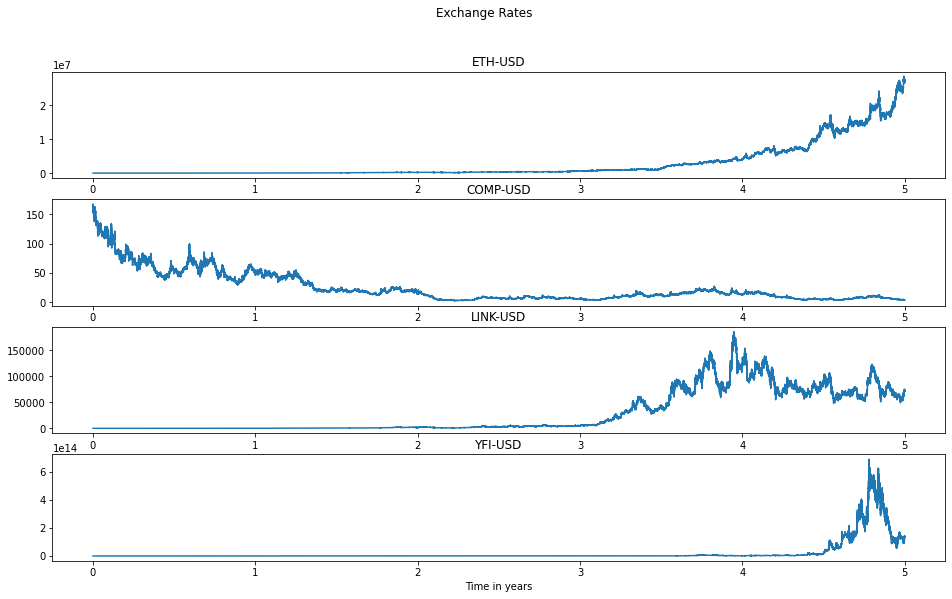

In [10]:
plot_multivariate_simulation(simulated_data=simulated_prices,
                             series_names=tickers, 
                             time_resolution=time_resolution, 
                             title='Exchange Rates')

In [11]:
ticker_to_time_series_of_prices_map = \
    construct_ticker_to_series_of_prices_map_from_simulated_prices(simulated_prices=simulated_prices, 
                                                                   tickers=tickers_with_ovl)

# Load Resampled Data

# Construct Agent Based Monetary Model

In [12]:
# TIME_RESOLUTION = TimeResolution.FIFTEEN_SECONDS
# DATA_SIM_RNG = 42

# Constants
STEPS_MONTH = int((86400*30)/time_resolution.in_seconds)

total_supply = 100000  # OVL
base_wealth = 0.0002*100000  # OVL
base_market_fee = 0.0030
base_max_leverage = 10.0
base_liquidate_reward = 0.1
base_maintenance = 0.6
liquidity = 0.285*total_supply
time_liquidity_mine = STEPS_MONTH
treasury = 0.0
sampling_interval = 240


# For the first 30 days, emit until reach 100% of total supply; ONLY USE IN LIQUDITIY FOR NOW JUST AS TEST!
liquidity_supply_emission = [(0.51*total_supply/time_liquidity_mine)*i + 0.285*total_supply
                             for i
                             in range(time_liquidity_mine)]

num_arbitrageurs = min(int(total_supply*0.1/base_wealth), 100)
num_keepers = int(total_supply*0.005/base_wealth)
# num_traders = int(total_supply*0.005/base_wealth)
num_traders = 0
# num_holders = int(total_supply*0.5/base_wealth)
num_holders = 0
num_snipers = min(int(total_supply*0.1/base_wealth), 100)
# num_liquidators = int(total_supply*0.005/base_wealth)
num_liquidators = 2 * (len(tickers) + 1)
num_agents = num_arbitrageurs + num_keepers + \
    num_traders + num_holders + num_snipers + num_liquidators

DATA_COLLECTOR_NAME = 'data_collector'
data_collection_options = \
    DataCollectionOptions(compute_gini_coefficient=False,
                          compute_wealth=False,
                          compute_inventory_wealth=False)

monetary_model = \
    MonetaryModel(num_arbitrageurs=num_arbitrageurs, 
                  num_keepers=num_keepers, 
                  num_traders=num_traders, 
                  num_holders=num_holders, 
                  num_snipers=num_snipers, 
                  num_liquidators=num_liquidators, 
                  base_maintenance=base_maintenance, 
                  base_liquidate_reward=base_liquidate_reward, 
                  sims=ticker_to_time_series_of_prices_map, 
                  base_wealth=base_wealth, 
                  base_market_fee=base_market_fee, 
                  base_max_leverage=base_max_leverage, 
                  liquidity=liquidity, 
                  liquidity_supply_emission=liquidity_supply_emission, 
                  treasury=treasury, 
                  sampling_interval=sampling_interval, 
                  data_collection_options=data_collection_options, 
                  seed=0)

print("Model kwargs for initial conditions of sim:")
print(f"num_arbitrageurs = {num_arbitrageurs}")
print(f"num_snipers = {num_snipers}")
print(f"num_keepers = {num_keepers}")
print(f"num_traders = {num_traders}")
print(f"num_holders = {num_holders}")
print(f"num_liquidators = {num_liquidators}")
print(f"total number of agents = {num_agents}")
print(f"base_wealth = {base_wealth}")

Model kwargs for initial conditions of sim:
num_arbitrageurs = 100
num_snipers = 100
num_keepers = 25
num_traders = 0
num_holders = 0
num_liquidators = 10
total number of agents = 235
base_wealth = 20.0


Drastically reduced the number of traders and holders to bring down the memory requirement for storing agent wealth (with the original numbers it would have been 7500 agents total). This would exceed the 128GB mem of my machine with 200000 steps

# Run Simulation

In [13]:
def run_model(number_of_steps_to_simulate: int):
    for i in tqdm(range(number_of_steps_to_simulate + 1)):
        monetary_model.step()

In [14]:
number_of_steps_to_simulate

5760

In [15]:
run_model(number_of_steps_to_simulate)

100%|██████████| 5761/5761 [00:26<00:00, 219.81it/s]


In [16]:
for market_name, market in monetary_model.fmarkets.items():
    print(f'open positions on {market_name} = {len(market.positions)}')

open positions on ETH-USD = 18
open positions on COMP-USD = 37
open positions on LINK-USD = 38
open positions on OVL-USD = 29


# Extract Model Variables

In [17]:
model_vars_df = monetary_model.data_collector.get_model_vars_dataframe()
model_vars_df.head()

,d-ETH-USD,d-COMP-USD,d-LINK-USD,d-OVL-USD,s-ETH-USD,s-COMP-USD,s-LINK-USD,s-OVL-USD,f-ETH-USD,f-COMP-USD,...,Skew COMP-USD,Skew LINK-USD,Skew OVL-USD,Number of Open Positions on ETH-USD,Number of Open Positions on COMP-USD,Number of Open Positions on LINK-USD,Number of Open Positions on OVL-USD,Supply,Treasury,Liquidity
0,0.000000,0.0,1.153482e-16,0.0,284.500432,157.1,7.699974,3565.0,284.500432,157.1,...,0.0,0.0,0.0,0,0,0,0,33200.0,0.0,28500.0
1,0.000000,0.0,1.153482e-16,0.0,284.500432,157.1,7.699974,3565.0,284.500432,157.1,...,0.0,0.0,0.0,0,0,0,0,33200.0,0.0,28500.0
2,-0.000596,0.0,-6.026242e-04,0.0,284.670019,157.1,7.704617,3565.0,284.500432,157.1,...,0.0,0.0,0.0,0,0,0,0,33200.0,0.0,28500.0
3,-0.000229,0.0,-8.763042e-04,0.0,284.565658,157.1,7.706728,3565.0,284.500432,157.1,...,0.0,0.0,0.0,0,0,0,0,33200.0,0.0,28500.0
4,-0.000092,0.0,-3.496026e-03,0.0,284.526523,157.1,7.726988,3565.0,284.500432,157.1,...,0.0,0.0,0.0,0,0,0,0,33200.0,0.0,28500.0


In [18]:
model_vars_df.memory_usage(deep=True)

Index                                     128
d-ETH-USD                               46096
d-COMP-USD                              46096
d-LINK-USD                              46096
d-OVL-USD                               46096
s-ETH-USD                               46096
s-COMP-USD                              46096
s-LINK-USD                              46096
s-OVL-USD                               46096
f-ETH-USD                               46096
f-COMP-USD                              46096
f-LINK-USD                              46096
f-OVL-USD                               46096
Skew ETH-USD                            46096
Skew COMP-USD                           46096
Skew LINK-USD                           46096
Skew OVL-USD                            46096
Number of Open Positions on ETH-USD     46096
Number of Open Positions on COMP-USD    46096
Number of Open Positions on LINK-USD    46096
Number of Open Positions on OVL-USD     46096
Supply                            

In [19]:
model_vars_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5762 entries, 0 to 5761
Data columns (total 23 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   d-ETH-USD                             5762 non-null   float64
 1   d-COMP-USD                            5762 non-null   float64
 2   d-LINK-USD                            5762 non-null   float64
 3   d-OVL-USD                             5762 non-null   float64
 4   s-ETH-USD                             5762 non-null   float64
 5   s-COMP-USD                            5762 non-null   float64
 6   s-LINK-USD                            5762 non-null   float64
 7   s-OVL-USD                             5762 non-null   float64
 8   f-ETH-USD                             5762 non-null   float64
 9   f-COMP-USD                            5762 non-null   float64
 10  f-LINK-USD                            5762 non-null   float64
 11  f-OVL-USD        

In [20]:
# fig = px.line(model_vars_df, y="Supply", title='OVL Supply')
# fig = px.line(model_vars_df, y="Treasury", title='Treasury')
# fig.show()

# Extract Agent Variables

In [21]:
agent_vars_df = monetary_model.data_collector.get_agent_vars_dataframe()
print(len(agent_vars_df))

1353835


In [22]:
agent_vars_df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1353835 entries, (0, 0) to (5760, 234)
Data columns (total 1 columns):
 #   Column  Non-Null Count    Dtype  
---  ------  --------------    -----  
 0   Wealth  1353835 non-null  float64
dtypes: float64(1)
memory usage: 15.7 MB


In [23]:
agent_vars_df.tail(300)

Wealth
Step AgentID           
5759 170      20.000000
     171      19.994000
     172      19.585542
     173      19.982000
     174      20.000000
...                 ...
5760 230      20.000000
     231      23.875577
     232      20.000000
     233      20.000000
     234      20.000000

[300 rows x 1 columns]

In [24]:
# agent_vars_df.loc[(699999, 1), :]
# df.loc[('cobra', 'mark i'), 'shield']

In [25]:
def convert_time_in_seconds_to_index(
    time_resolution: TimeResolution, 
    time_in_seconds: float):
    return int(np.floor(time_in_seconds / time_resolution.in_seconds))

In [26]:
one_year_index = \
    convert_time_in_seconds_to_index(
        time_resolution=time_resolution, 
        time_in_seconds=365.25 * 24 * 60 * 60)
one_year_index

2103840

In [27]:
one_day_index = \
    convert_time_in_seconds_to_index(
        time_resolution=time_resolution, 
        time_in_seconds=24 * 60 * 60)
one_day_index

5760

In [28]:
# agent_wealth = agent_vars_df.loc[pd.IndexSlice[one_year_index, :], :].values
agent_wealth = agent_vars_df.loc[pd.IndexSlice[one_day_index, :], :].values

In [29]:
agent_wealth.shape

(235, 1)

In [30]:
agent_wealth.sum()

4652.393708531321

In [31]:
def arbitrageur_indices():
    return 0, num_arbitrageurs


def keeper_indices():
    return num_arbitrageurs, num_arbitrageurs+num_keepers


def sniper_indices():
    begin_index = num_arbitrageurs + num_keepers + num_holders + num_traders
    end_index = num_arbitrageurs + num_keepers + num_holders + num_traders + num_snipers
    return begin_index, end_index

In [32]:
sorted(agent_wealth[sniper_indices()[0]:sniper_indices()[1]])

[array([0.4278528]),
 array([5.09335033]),
 array([19.58554243]),
 array([19.676]),
 array([19.676]),
 array([19.712]),
 array([19.73]),
 array([19.76]),
 array([19.784]),
 array([19.79]),
 array([19.82]),
 array([19.832]),
 array([19.83404004]),
 array([19.838]),
 array([19.838]),
 array([19.838]),
 array([19.856]),
 array([19.874]),
 array([19.904]),
 array([19.916]),
 array([19.928]),
 array([19.928]),
 array([19.94]),
 array([19.94]),
 array([19.94007196]),
 array([19.946]),
 array([19.94606475]),
 array([19.952]),
 array([19.952]),
 array([19.95204318]),
 array([19.95205037]),
 array([19.95803778]),
 array([19.964]),
 array([19.964]),
 array([19.964]),
 array([19.964]),
 array([19.964]),
 array([19.97]),
 array([19.97]),
 array([19.976]),
 array([19.976]),
 array([19.976]),
 array([19.976]),
 array([19.976]),
 array([19.976]),
 array([19.976]),
 array([19.976]),
 array([19.976]),
 array([19.982]),
 array([19.982]),
 array([19.982]),
 array([19.982]),
 array([19.982]),
 array([19.9

In [33]:
sorted(agent_wealth[keeper_indices()[0]:keeper_indices()[1]])

[array([20.]),
 array([20.]),
 array([20.]),
 array([20.]),
 array([20.]),
 array([20.]),
 array([20.]),
 array([20.]),
 array([20.]),
 array([20.]),
 array([20.]),
 array([20.]),
 array([20.]),
 array([20.]),
 array([20.]),
 array([20.]),
 array([20.]),
 array([20.]),
 array([20.]),
 array([20.]),
 array([20.]),
 array([20.]),
 array([20.]),
 array([20.]),
 array([20.])]

In [34]:
sorted(agent_wealth[arbitrageur_indices()[0]:arbitrageur_indices()[1]])

[array([9.89660689]),
 array([11.18114226]),
 array([12.70738818]),
 array([13.37956412]),
 array([13.91742621]),
 array([14.31056994]),
 array([15.5717274]),
 array([15.96191377]),
 array([16.63771587]),
 array([17.0279775]),
 array([18.53881755]),
 array([18.6275847]),
 array([18.67114211]),
 array([18.70767618]),
 array([18.81079181]),
 array([18.84879134]),
 array([19.05897092]),
 array([19.36298013]),
 array([19.54363317]),
 array([19.58288001]),
 array([19.58693694]),
 array([19.59325805]),
 array([19.68945055]),
 array([19.6928914]),
 array([19.71807562]),
 array([19.72191496]),
 array([19.74905692]),
 array([19.78477667]),
 array([19.79294128]),
 array([19.82053946]),
 array([19.85634532]),
 array([19.88018]),
 array([19.90354375]),
 array([19.904]),
 array([19.904]),
 array([19.904]),
 array([19.9041152]),
 array([19.90882018]),
 array([19.91580954]),
 array([19.916]),
 array([19.916]),
 array([19.916]),
 array([19.91621453]),
 array([19.928]),
 array([19.928]),
 array([19.928

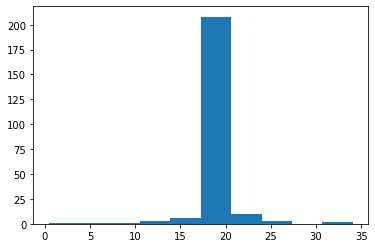

In [35]:
histogram = plt.hist(agent_vars_df.loc[pd.IndexSlice[one_day_index, :], :].values)

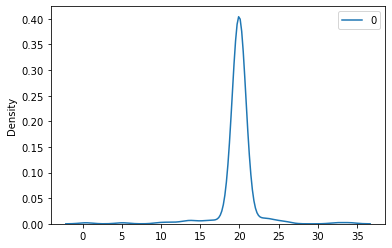

In [36]:
sns.kdeplot(data=agent_wealth);

# Plot Results

## New Plots with 100 Arbitrageurs and 100 Snipers (no traders and no holders)

In [37]:
plot_time_scale = TimeScale.YEARS

### Set Plot Horizon in Seconds

In [38]:
plot_begin_years = 0.0
# plot_end_years = 5 * 365.25 * 24 * 60 * 60  # 5 years
# plot_end_years = 0.75 * 365.25 * 24 * 60 * 60  # 9 months
plot_end_years = 1 * 365.25 * 24 * 60 * 60  # 1 year
time_interval_to_plot_in_seconds = (plot_begin_years, plot_end_years)
time_interval_to_plot_in_seconds = None

### OVL Supply

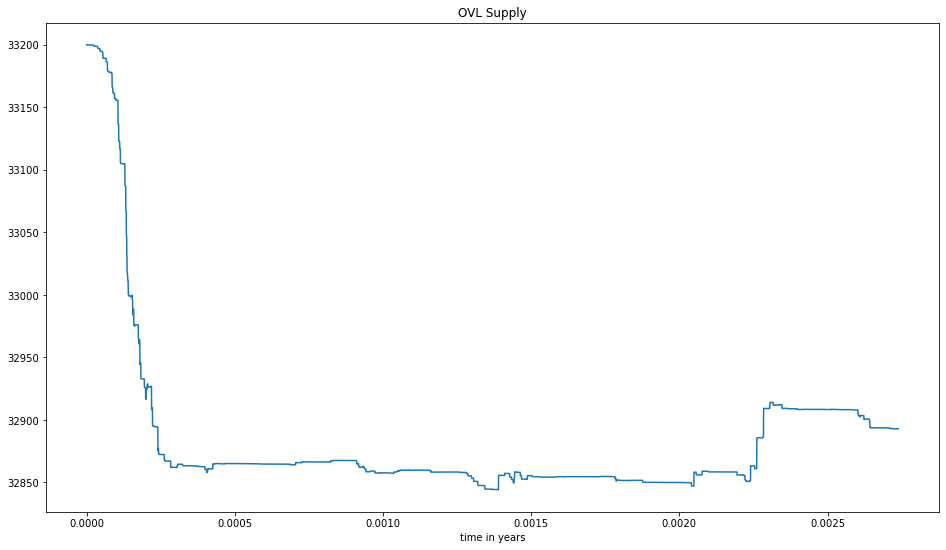

In [39]:
plot_supply(model_vars_df=model_vars_df, 
            plot_time_scale=plot_time_scale, 
            time_interval_to_plot_in_seconds=time_interval_to_plot_in_seconds, 
            time_resolution=time_resolution, 
            data_interval=data_collection_options.data_collection_interval)

### Liquidity

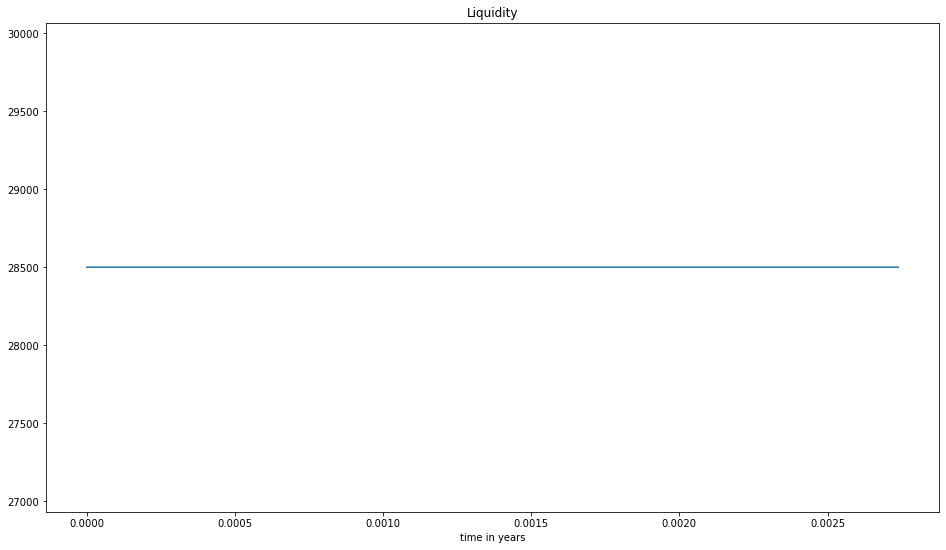

In [40]:
plot_liquidity(model_vars_df=model_vars_df,  
               plot_time_scale=plot_time_scale, 
               time_interval_to_plot_in_seconds=time_interval_to_plot_in_seconds, 
               time_resolution=time_resolution, 
               data_interval=data_collection_options.data_collection_interval)

### Treasury

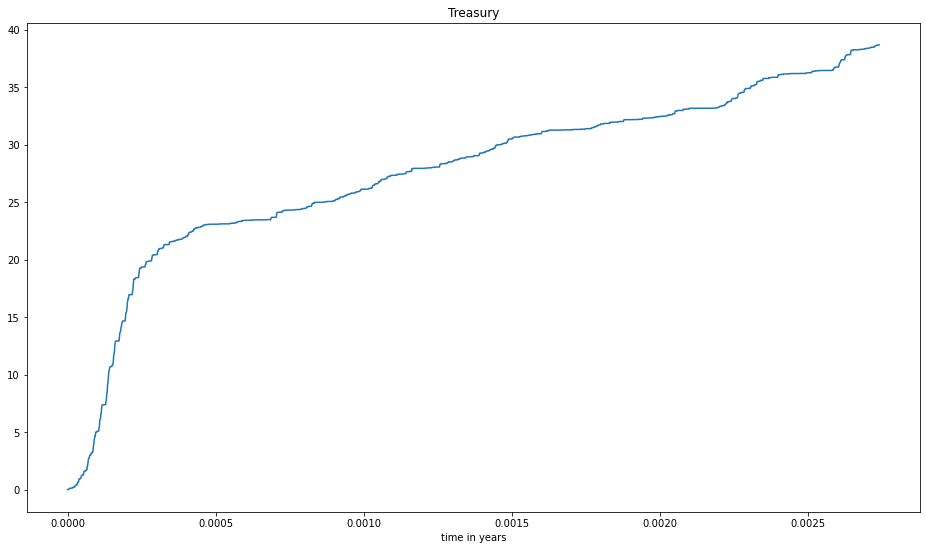

In [41]:
plot_treasury(model_vars_df=model_vars_df, 
              plot_time_scale=plot_time_scale, 
            time_interval_to_plot_in_seconds=time_interval_to_plot_in_seconds, 
              time_resolution=time_resolution, 
              data_interval=data_collection_options.data_collection_interval)

### Price Deviations

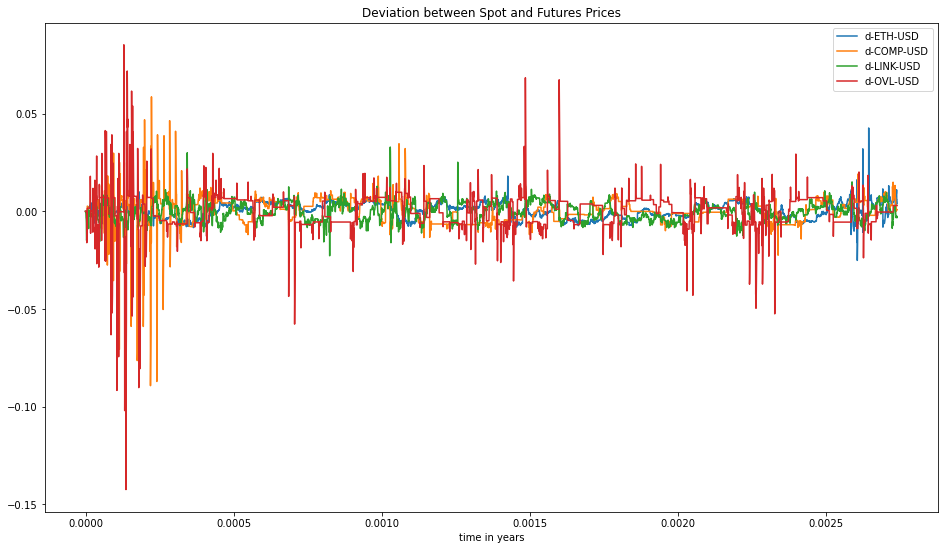

In [42]:
plot_price_deviations(
    model_vars_df=model_vars_df, 
    tickers=tickers_with_ovl, 
    plot_time_scale=plot_time_scale, 
    time_resolution=time_resolution, 
    time_interval_to_plot_in_seconds=time_interval_to_plot_in_seconds, 
    data_interval=data_collection_options.data_collection_interval)

### Skew

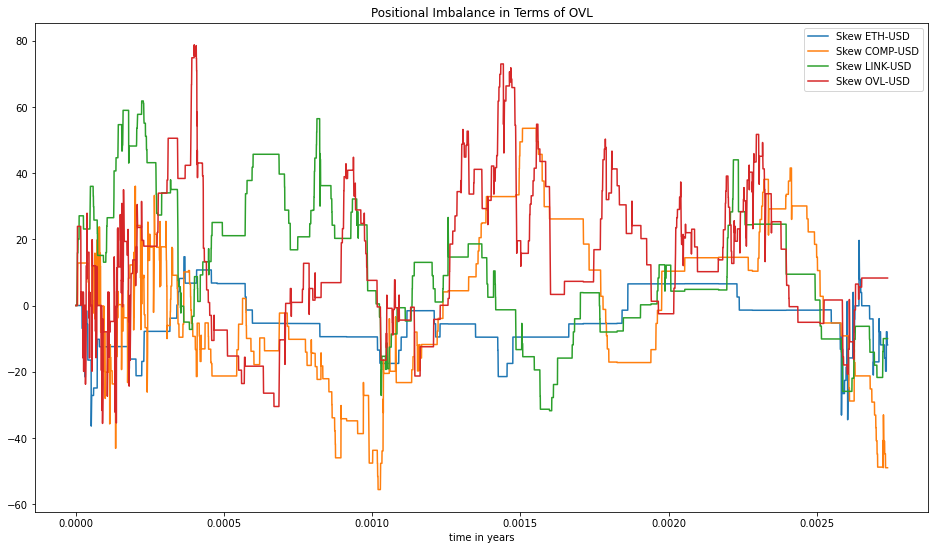

In [43]:
plot_skews(
    model_vars_df=model_vars_df, 
    tickers=tickers_with_ovl, 
    plot_time_scale=plot_time_scale, 
    time_resolution=time_resolution, 
    time_interval_to_plot_in_seconds=time_interval_to_plot_in_seconds, 
    data_interval=data_collection_options.data_collection_interval)

#### Correlation between Skew and Futures Price

In [44]:
for i, ticker in enumerate(tickers_with_ovl):
    if i > 0:
        break
    skew = model_vars_df.loc[:, skew_label(ticker)].values
    futures_price = model_vars_df.loc[:, futures_price_label(ticker)].values
    spot_price = model_vars_df.loc[:, spot_price_label(ticker)].values
    print(np.corrcoef(skew, futures_price))
    print(np.corrcoef(skew, spot_price))

[[1.         0.14345399]
 [0.14345399 1.        ]]
[[1.         0.11267677]
 [0.11267677 1.        ]]


### Number of Open Positions

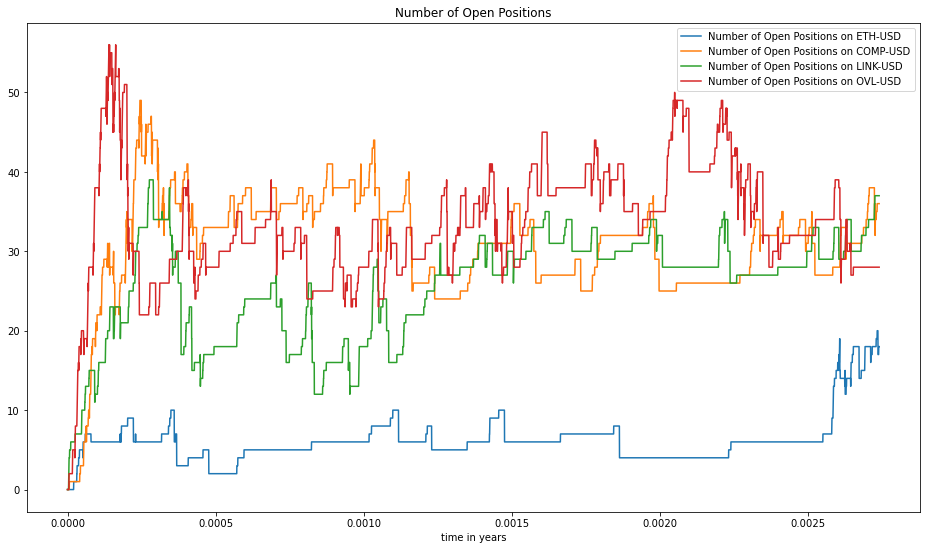

In [45]:
plot_open_positions(
    model_vars_df=model_vars_df, 
    tickers=tickers_with_ovl, 
    plot_time_scale=plot_time_scale, 
    time_resolution=time_resolution, 
    time_interval_to_plot_in_seconds=time_interval_to_plot_in_seconds, 
    data_interval=data_collection_options.data_collection_interval)

### Spot vs. Futures Prices

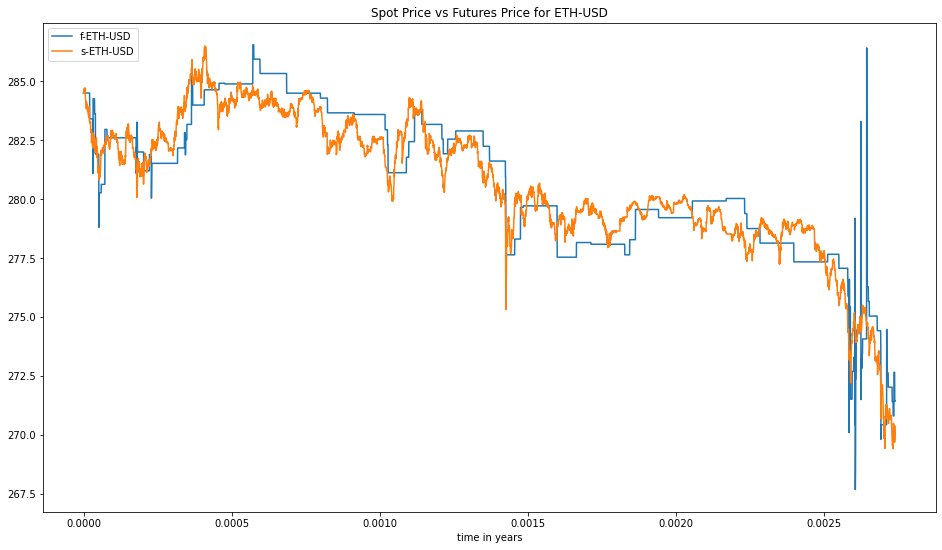

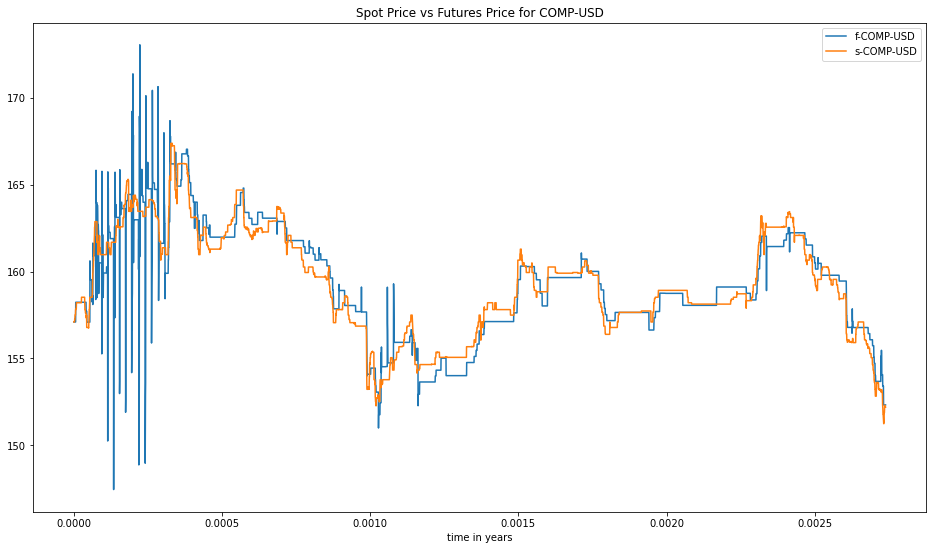

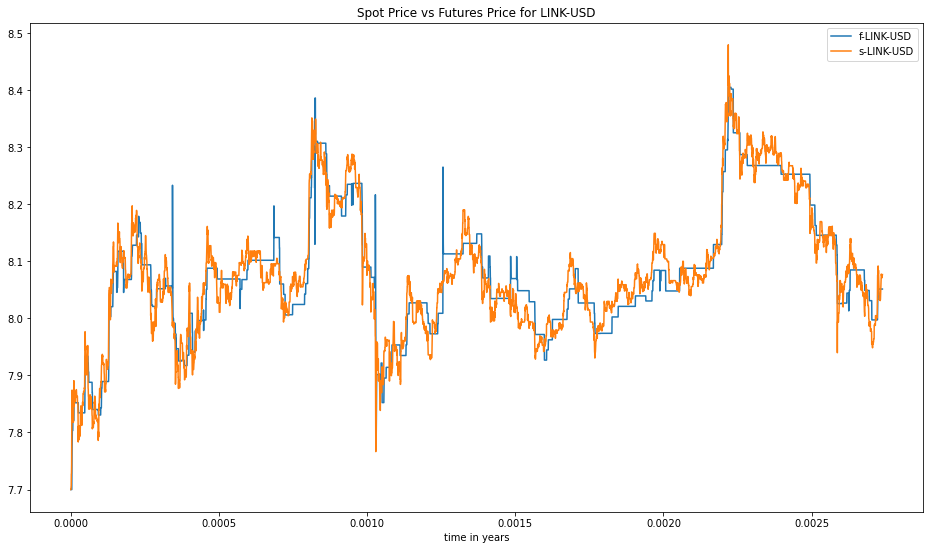

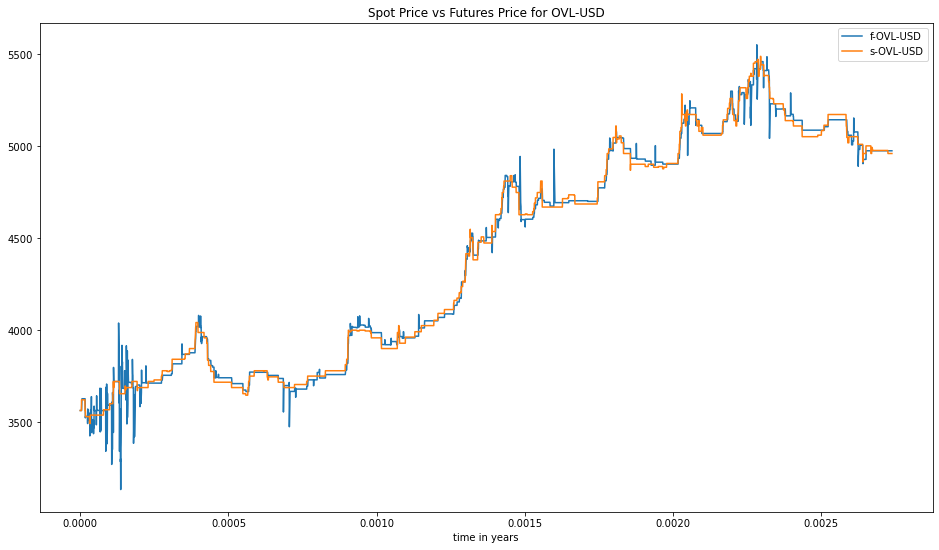

In [46]:
for i, ticker in enumerate(tickers_with_ovl):
    plot_spot_vs_futures_price(
        model_vars_df=model_vars_df, 
        ticker=ticker, 
        plot_time_scale=plot_time_scale, 
        time_resolution=time_resolution, 
        time_interval_to_plot_in_seconds=time_interval_to_plot_in_seconds, 
        data_interval=data_collection_options.data_collection_interval)

In [47]:
# %lprun \
#     -f compute_gini \
#     -f compute_price_difference \
#     -f compute_futures_price \
#     -f compute_spot_price \
#     -f compute_supply \
#     -f compute_liquidity \
#     -f compute_treasury \
#     -f compute_wealth_for_agent_type \
#     -f compute_inventory_wealth_for_agent \
#     -f compute_inventory_wealth_for_agent_type \
#     -f compute_positional_imbalance_by_market \
#     -f DataCollector.collect \
#     -f MonetaryAgent.step \
#     -f MonetaryArbitrageur._unwind_positions \
#     -f MonetaryArbitrageur._unwind_next_position \
#     -f MonetaryArbitrageur.trade \
#     -f MonetaryArbitrageur.step \
#     -f MonetaryKeeper.step \
#     -f MonetaryKeeper.distribute_funding \
#     -f MonetaryLiquidator.scope_liquidations \
#     -f MonetaryLiquidator.step \
#     -f MonetarySniper._get_unwind_amount \
#     -f MonetarySniper._unwind_positions \
#     -f MonetarySniper._get_filled_price \
#     -f MonetarySniper._get_size \
#     -f MonetarySniper._get_effective_edge \
#     -f MonetarySniper.trade \
#     -f MonetaryFMarket.build \
#     -f MonetaryFMarket.unwind \
#     -f MonetaryFMarket._swap \
#     -f MonetaryFMarket.slippage \
#     -f MonetaryFMarket.fund \
#     -f MonetaryFMarket.funding \
#     -f MonetaryFMarket.liquidatable \
#     -f MonetaryFMarket.liquidate \
#     -f MonetaryModel.step \
#     run_model(number_of_steps_to_simulate)

In [48]:
# plt.close('all')